# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [28]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [30]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

In [31]:
train_X

array([[0.        , 0.87865169, 1.        , ..., 0.05182215, 0.57142857,
        1.        ],
       [0.5       , 0.51348315, 1.        , ..., 0.08115719, 0.        ,
        0.33333333],
       [1.        , 0.03370787, 0.        , ..., 0.06104473, 0.        ,
        1.        ],
       ...,
       [1.        , 0.52247191, 0.        , ..., 0.04970769, 0.        ,
        1.        ],
       [1.        , 0.21797753, 1.        , ..., 0.01985208, 0.        ,
        1.        ],
       [1.        , 0.98876404, 1.        , ..., 0.02822072, 0.        ,
        0.33333333]])

In [32]:
train_X.shape

(222, 10)

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

In [33]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

"""
Your Code Here (Hint : 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可, 本作業其餘寫法相同)
"""

rf.fit(train_X, train_Y)
onehot.fit(rf.apply(train_X))
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
rf.fit(train_X, train_Y)
rf.apply(train_X)
#onehot.fit(rf.apply(train_X))
#rf.apply(train_X)

array([[ 9,  4, 12, ..., 12, 10,  6],
       [12, 11,  4, ...,  9,  4, 13],
       [11, 13,  7, ...,  3,  7, 11],
       ...,
       [ 4, 13,  7, ...,  5,  7, 11],
       [12, 13,  7, ...,  9,  7, 14],
       [ 2,  4,  6, ...,  8,  3,  7]], dtype=int64)

In [35]:
rf.apply(train_X).shape

(222, 20)

In [36]:
onehot.fit(rf.apply(train_X))
rf.apply(train_X)

array([[ 9,  4, 12, ..., 12, 10,  6],
       [12, 11,  4, ...,  9,  4, 13],
       [11, 13,  7, ...,  3,  7, 11],
       ...,
       [ 4, 13,  7, ...,  5,  7, 11],
       [12, 13,  7, ...,  9,  7, 14],
       [ 2,  4,  6, ...,  8,  3,  7]], dtype=int64)

In [7]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
"""
Your Code Here 
"""
pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(test_X)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)

# 將隨機森林結果輸出
"""
Your Code Here 
"""
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

In [8]:
rf.predict_proba(test_X)

array([[0.80804843, 0.19195157],
       [0.81172164, 0.18827836],
       [0.3466588 , 0.6533412 ],
       [0.87337577, 0.12662423],
       [0.39346479, 0.60653521],
       [0.50858404, 0.49141596],
       [0.41041369, 0.58958631],
       [0.44597943, 0.55402057],
       [0.85334633, 0.14665367],
       [0.83821845, 0.16178155],
       [0.5552083 , 0.4447917 ],
       [0.86513244, 0.13486756],
       [0.82939492, 0.17060508],
       [0.78796635, 0.21203365],
       [0.38972199, 0.61027801],
       [0.81105843, 0.18894157],
       [0.87337577, 0.12662423],
       [0.82537445, 0.17462555],
       [0.49195416, 0.50804584],
       [0.6760297 , 0.3239703 ],
       [0.66163027, 0.33836973],
       [0.36071284, 0.63928716],
       [0.53954874, 0.46045126],
       [0.82371923, 0.17628077],
       [0.60023371, 0.39976629],
       [0.81105843, 0.18894157],
       [0.46639066, 0.53360934],
       [0.8581149 , 0.1418851 ],
       [0.37523023, 0.62476977],
       [0.43455613, 0.56544387],
       [0.

In [9]:
roc_curve(test_Y, pred_rf)

(array([0.        , 0.        , 0.        , 0.00371747, 0.00371747,
        0.00371747, 0.00371747, 0.00743494, 0.00743494, 0.00743494,
        0.00743494, 0.00743494, 0.00743494, 0.01115242, 0.01858736,
        0.01858736, 0.01858736, 0.02230483, 0.02230483, 0.02230483,
        0.02230483, 0.02230483, 0.02230483, 0.02973978, 0.02973978,
        0.03717472, 0.03717472, 0.04089219, 0.04089219, 0.04460967,
        0.04460967, 0.04832714, 0.04832714, 0.05204461, 0.05204461,
        0.05576208, 0.05576208, 0.07063197, 0.07063197, 0.07434944,
        0.07434944, 0.07806691, 0.07806691, 0.08178439, 0.08921933,
        0.08921933, 0.0929368 , 0.0929368 , 0.10037175, 0.10780669,
        0.11524164, 0.11524164, 0.12267658, 0.12267658, 0.12639405,
        0.12639405, 0.13011152, 0.13754647, 0.14126394, 0.14869888,
        0.14869888, 0.15241636, 0.15241636, 0.1598513 , 0.1598513 ,
        0.17100372, 0.17100372, 0.17100372, 0.18587361, 0.18587361,
        0.18959108, 0.18959108, 0.19330855, 0.19

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

差異似乎不大

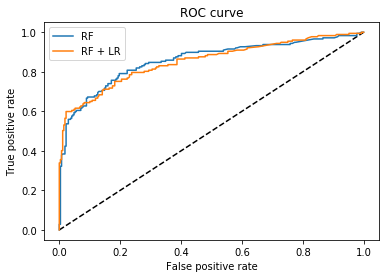

In [6]:
import matplotlib.pyplot as plt
# 將結果繪圖
"""
Your Code Here 
"""

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()